In [77]:
from commstools import Signal
from commstools.impairments import apply_awgn, apply_pmd
import numpy as np


In [78]:
NUM_SYMBOLS = 2**18
SYMBOL_RATE = 1e9
SPS = 2
MOD = "QAM"
ORDER = 16
ESN0_DB = 20
DGD_SYMBOLS = 0.0
THETA = np.pi / 4


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 16
3,Symbol Rate,1.00 GBaud
4,Bit Rate,4.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


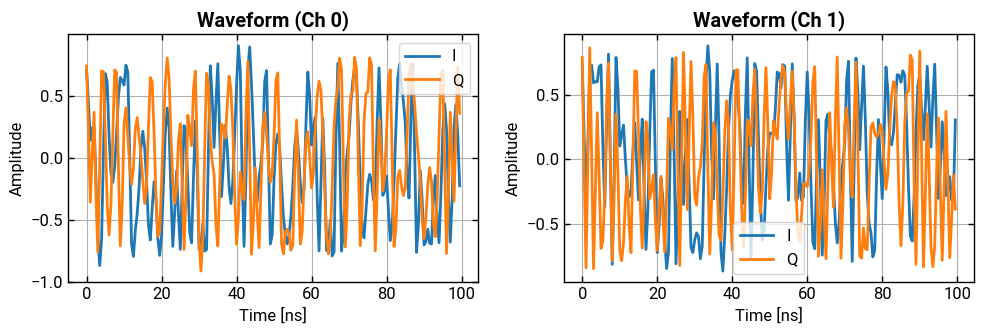

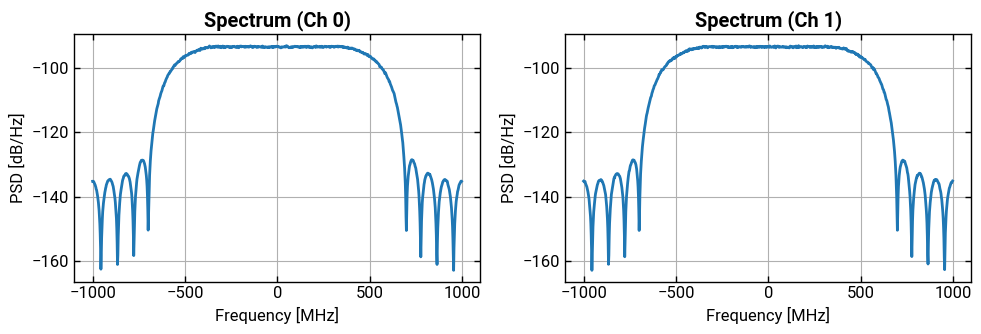

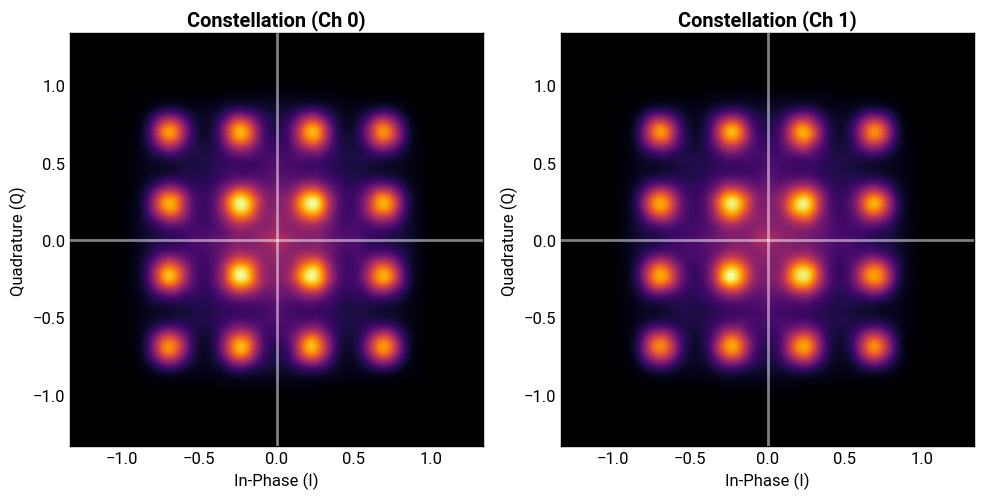

In [79]:
sig = Signal.qam(
    num_symbols=NUM_SYMBOLS,
    sps=SPS,
    symbol_rate=SYMBOL_RATE,
    order=ORDER,
    num_streams=2,
    seed=42,
)
sig.print_info()
sig.plot_waveform(num_symbols=100, show=True)
sig.plot_psd(show=True, nperseg=2**10)
sig.plot_constellation(show=True)


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 16
3,Symbol Rate,1.00 GBaud
4,Bit Rate,4.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


2026-02-22 20:17:27 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 20.00 dB).


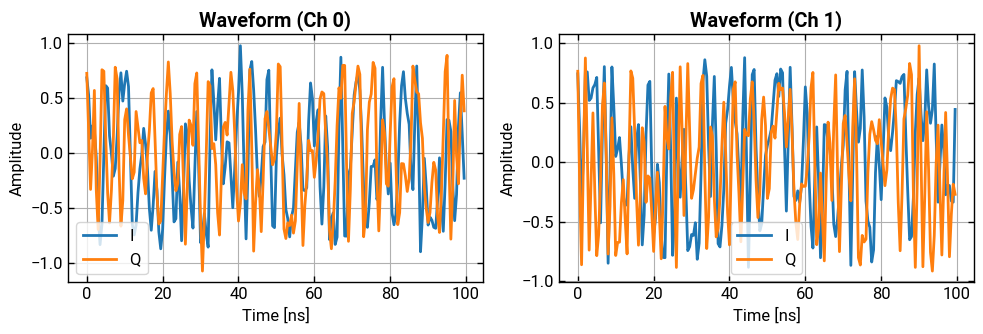

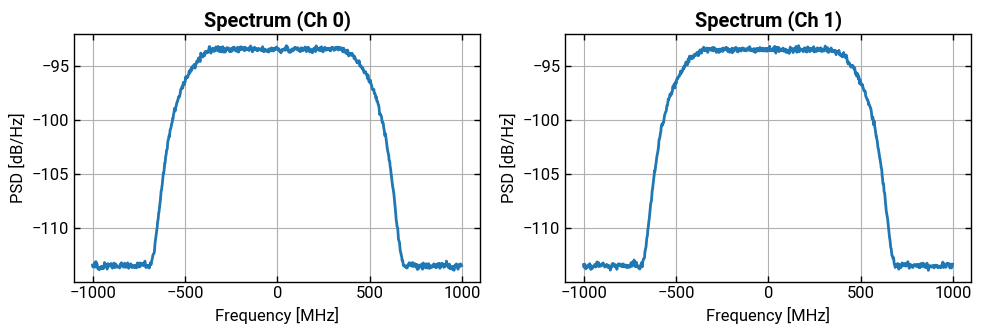

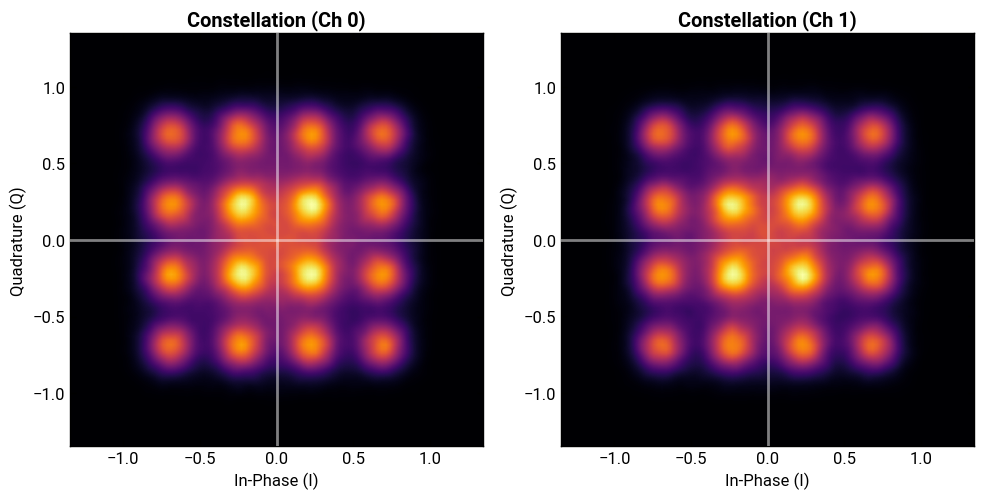

In [80]:
sig_dist = sig.copy()

sig_dist.print_info()
sig_dist = apply_awgn(sig_dist, esn0_db=ESN0_DB)
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 20:17:28 [INFO] [commstools/impairments.py] Applying PMD (DGD=0.00e+00 s, theta=0.785 rad).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 16
3,Symbol Rate,1.00 GBaud
4,Bit Rate,4.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


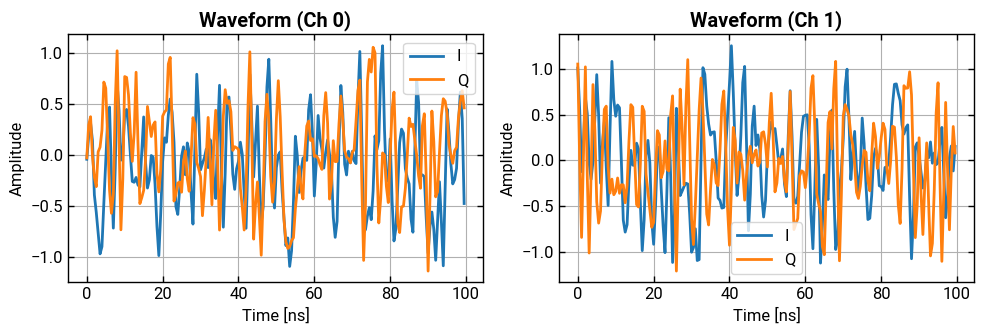

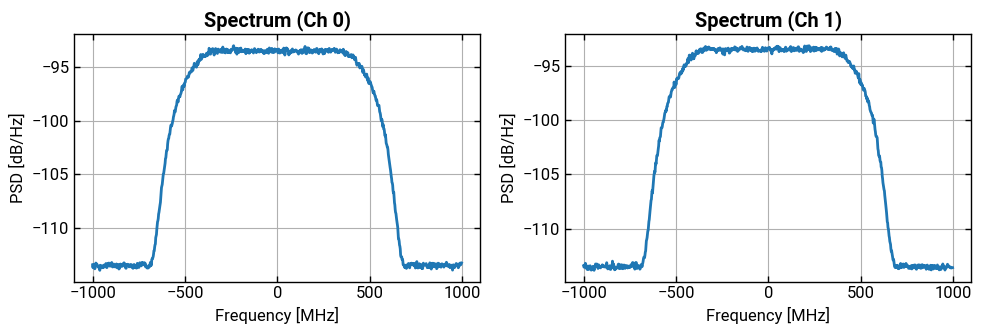

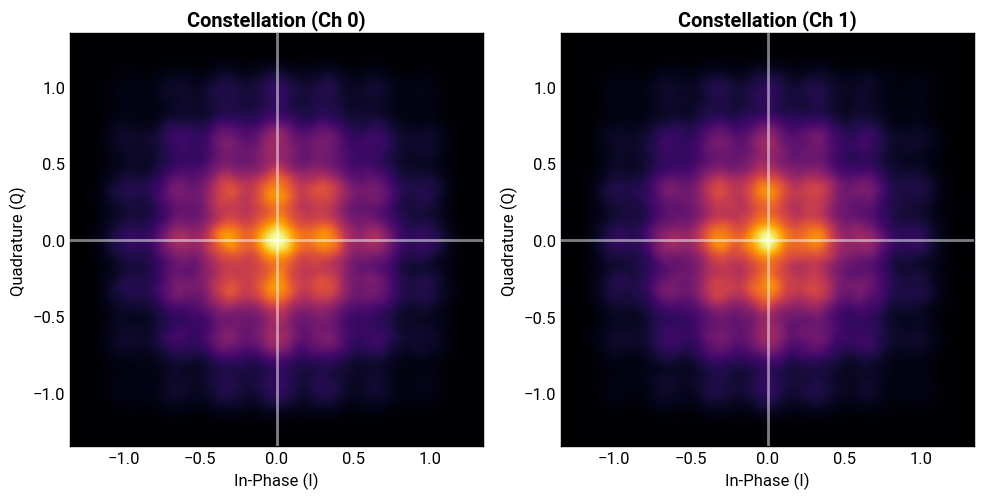

In [81]:
sig_dist = apply_pmd(sig_dist, dgd=DGD_SYMBOLS / SYMBOL_RATE, theta=THETA)

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 20:17:28 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


,Property,Value
0,Spectral Domain,BASEBAND
1,Physical Domain,DIG
2,Modulation (Scheme/Order),QAM / 16
3,Symbol Rate,1.00 GBaud
4,Bit Rate,4.00 Gbps
5,Sampling Rate,2.00 GHz
6,Samples Per Symbol,2.00
7,Pulse Shape,RRC
8,Duration,262.14 µs
9,Center Frequency,0.00 Hz


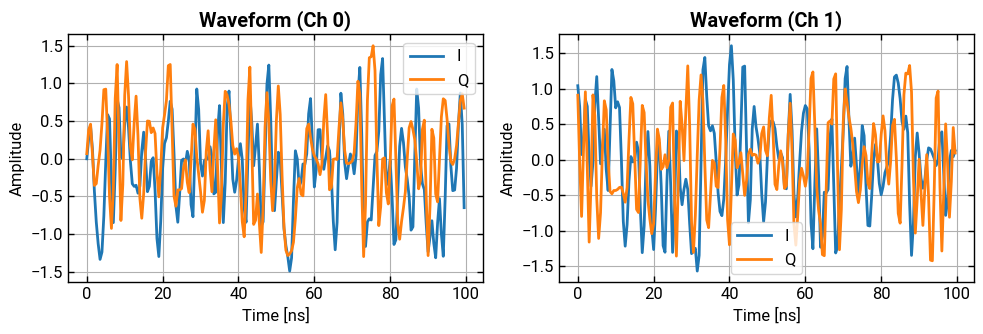

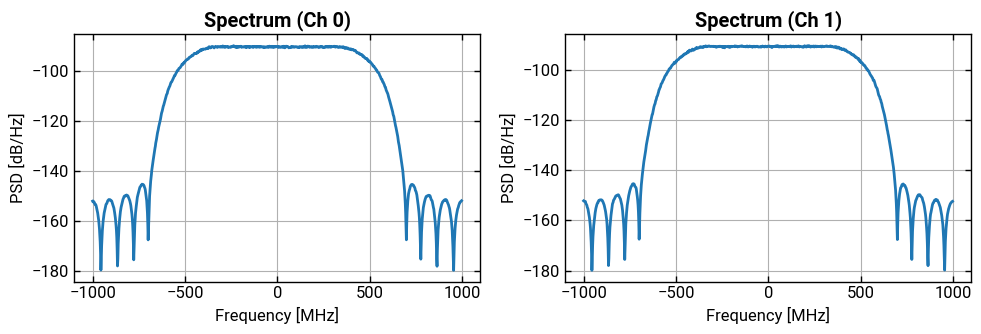

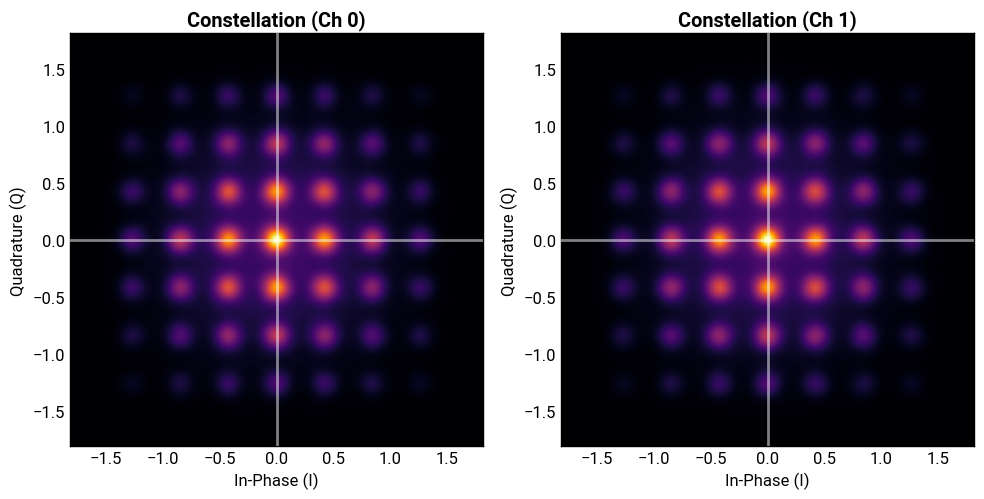

In [82]:
sig_dist.matched_filter()

sig_dist.print_info()
sig_dist.plot_waveform(num_symbols=100, show=True)
sig_dist.plot_psd(show=True, nperseg=2**10)
sig_dist.plot_constellation(show=True)


2026-02-22 20:19:37 [INFO] [commstools/equalizers.py] RLS equalizer: num_taps=23, lambda=0.99, sps=2, block_size=1


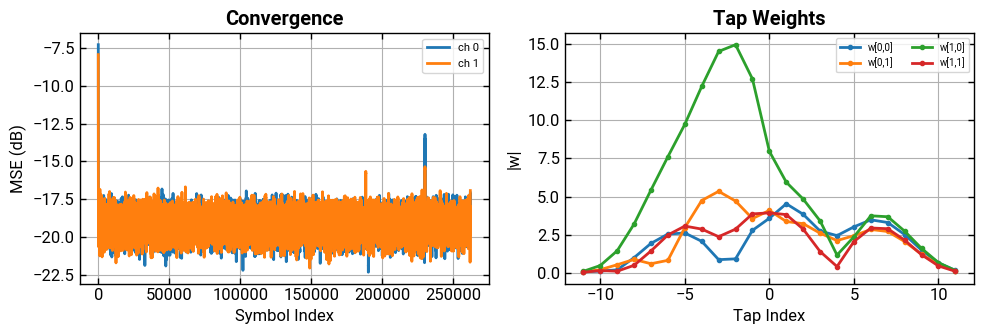

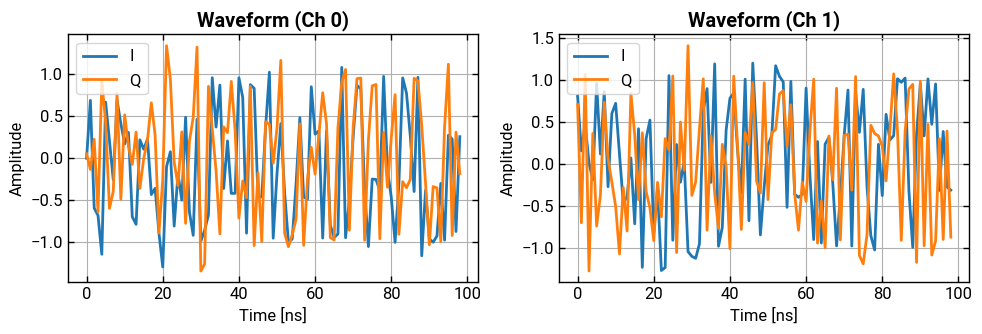

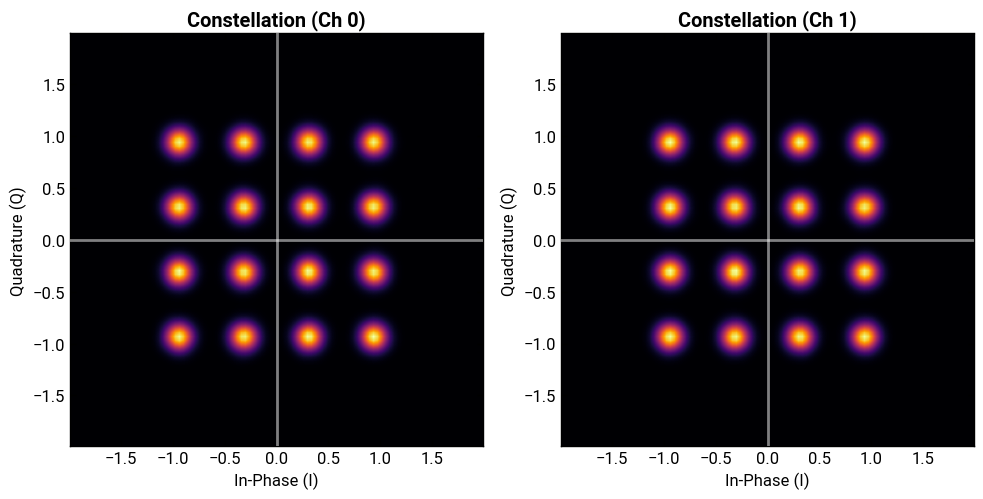

2026-02-22 20:19:41 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.
2026-02-22 20:19:41 [INFO] [commstools/core.py] Discarding 256 training symbols for EVM calculation.
2026-02-22 20:19:41 [INFO] [commstools/metrics.py] EVM Ch0: 11.16% (-19.05 dB)
2026-02-22 20:19:41 [INFO] [commstools/metrics.py] EVM Ch1: 11.15% (-19.06 dB)


(array([11.157565, 11.146595], dtype=float32),
 array([-19.04861 , -19.057156], dtype=float32))

In [ ]:
sig_to_eq = sig_dist.copy()

sig_to_eq.equalize(
    method="rls",
    # step_size=0.1,
    num_train_symbols=2**8,
    # forgetting_factor=0.9,
    block_size=1,
    num_taps=23,
    device="cpu",
)
sig_to_eq.plot_equalizer(show=True)

sig_to_eq.plot_waveform(num_symbols=99, show=True)
sig_to_eq.plot_constellation(show=True)
sig_to_eq.resolve_symbols()
sig_to_eq.evm()


In [84]:
sig_to_eq.resolved_symbols


array([[-0.00202503+0.06904655j,  0.44926536+0.47285762j,
        -0.45063406-0.3685573j , ...,  0.01898588-0.9914637j ,
         1.107186  +0.11380821j,  0.8022002 -0.8564465j ],
       [ 1.0915781 +0.9519586j ,  0.07959425-0.8321717j ,
         0.89032763+1.0043572j , ...,  0.83935785-0.10978302j,
         0.15065499+0.3560669j ,  0.65308034-0.18908137j]],
      shape=(2, 262144), dtype=complex64)

In [85]:
sig_to_eq.source_symbols


array([[ 0.9492774 +0.9492774j ,  0.3164258 -0.3164258j ,
         0.3164258 +0.3164258j , ...,  0.3164258 -0.9492774j ,
         0.9492774 +0.3164258j ,  0.9492774 -0.9492774j ],
       [ 0.94884837+0.94884837j, -0.31628278-0.94884837j,
         0.94884837+0.94884837j, ...,  0.94884837+0.31628278j,
        -0.31628278+0.31628278j,  0.31628278+0.31628278j]],
      shape=(2, 262144), dtype=complex64)

In [86]:
51 // 2


25

In [87]:
for i in range(0, 13):
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12


In [88]:
13 // 2


6